In [193]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import pycbc.conversions as conv

from gwbench import injections
from gwbench import network
from gwbench import snr

In [171]:
plotdir = 'power_law_hyper_param_plots/'

alpha_inj = -3.5
mmin_inj = 5.0
mmax_inj = 100.

import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)

# Read simulation

In [172]:
# File with Mc biases

# files = [f'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc.csv']
# files = ['powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_2400_4800.csv', \
#     'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_4800_7200.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_7200_10080.csv']

# files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc.csv']
files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc.csv', 'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc_2400_10080.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
# df_mc_raw = df_mc_raw[df_mc_raw["m1"] < 20]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))


Total number of events: 10080


In [173]:
# File with eta biases

# files = [f'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta.csv']
# files = ['powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_2400_4800.csv', \
    # 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_4800_7200.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_7200_10080.csv']
#
# files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta.csv']
files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta.csv', 'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta_2400_10080.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
# df_eta_raw = df_eta_raw[df_eta_raw["m1"] < 20]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 10080


## Sample from the events if needed

In [174]:
# # Select random subset of the data
# n_samples = 1200
# sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
# df_mc = df_mc_raw.iloc[sample_indices]
# df_eta = df_eta_raw.iloc[sample_indices]

# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

print(len(df_mc))
print(np.median(df_mc["Mc"]))

10080
14.235779623328058


$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

(4.0, 7.0)

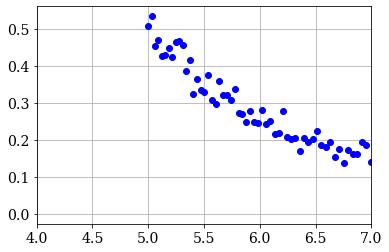

In [175]:
bins = np.geomspace(5, 100, 500)

m1_inj = df_mc["m1"]/(1+df_mc["z"])
y, X = np.histogram(m1_inj, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'bo', label='Injected')
plt.grid()
plt.xlim(4, 7)

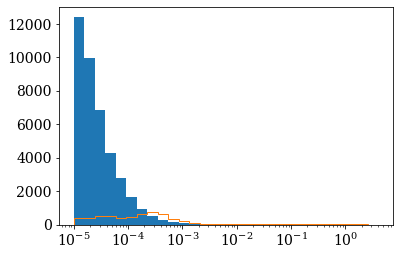

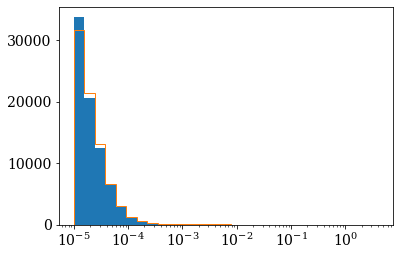

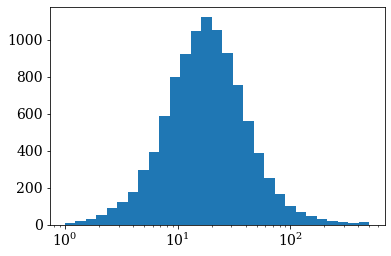

In [176]:
bins=np.geomspace(0.00001,4.0, 30)

plt.hist(df_mc_raw["bias_1"], bins=bins, density=True)
plt.hist(df_mc_raw["bias_1"][df_mc_raw["Mc"]>20], bins=bins, density=True, histtype="step")
plt.semilogx()
plt.show()
plt.hist(df_eta_raw["bias_1"], bins=bins, density=True)
plt.hist(df_eta_raw["bias_1"][df_eta_raw["snr"]>8], bins=bins, density=True, histtype="step")
plt.semilogx()
plt.show()

plt.hist(df_eta_raw["snr"], bins=np.geomspace(1, 500, 30))
plt.semilogx()
plt.show()

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) + log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s + \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [177]:
def sample_m1_events(df_mc, df_eta, biased=False):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc_raw = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m1_mu_detections = df_mc["m1"] / (1+z)

    aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
    aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
    m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
    m1_sigma_events = m1_sigma_events.values

    if biased:
        bias_mc = df_mc["bias_19"]
        bias_eta = df_eta["bias_19"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m1_mu_detections = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    # m1_mu_sampled = stats.truncnorm.rvs(0, 1000, m1_mu_detections, m1_sigma_events)
    m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

    return m1_mu_sampled, m1_sigma_events

In [340]:
def get_cofidence_int_1d(log_norm, range):
    # 68% confidence interval using KDE
    cdf_likelihood = integrate.cumulative_trapezoid(np.exp(log_norm), range, initial=0)
    cdf_likelihood = cdf_likelihood/np.max(cdf_likelihood)

    # make sure the cdf is strictly increasing to interpolate
    index_min = np.where(cdf_likelihood == np.min(cdf_likelihood))[0][0]
    index_max = np.where(cdf_likelihood == np.max(cdf_likelihood))[0][0]

    inv_cdf_interp = interpolate.interp1d(cdf_likelihood[index_min:index_max], range[index_min:index_max], fill_value="extrapolate")


    med = inv_cdf_interp(0.5)
    sig_pos = inv_cdf_interp(0.84)
    sig_neg = inv_cdf_interp(0.26)

    return med, sig_pos, sig_neg

In [178]:
def p_m1(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma, amp=1.0):
    A = np.sqrt(2*np.pi) * sigma
    return amp * np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A
    # return stats.norm.pdf(m1, loc=mu, scale=sigma)

def trunc_normal_dist(m1, mu, sigma, m_min=None, m_max=None):
    if m_min is None:
        m_min = np.min(m1)
    if m_max is None:
        m_max = np.max(m1)
        
    a, b = (m_min - mu) / sigma, (m_max - mu) / sigma
    return stats.truncnorm.pdf(m1, a, b, loc = mu, scale = sigma)

def sigmoid(x, a):
    return 1/(1 + np.exp(a-x))

In [179]:
m1_min=5
m1_max=100
alpha=-3.5


m1 = np.linspace(m1_min, m1_max, 300000)
print(integrate.trapezoid(p_m1(m1, alpha, m1_min, m1_max), m1))

1.0000000007123995


In [180]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 34
sigma = 1.4
print(integrate.trapezoid(normal_dist(m1, mu, sigma), m1))

1.0


In [181]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 134
sigma = 1.4
print(integrate.trapezoid(trunc_normal_dist(m1, mu, sigma), m1))

1.0000025188661694


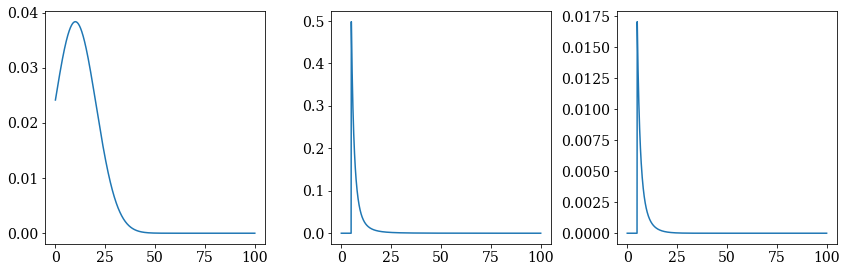

In [182]:
# Visualize the defined functions for sanity

m1_min=5
m1_max=100

m1 = np.linspace(0, m1_max, 1000)
mu = 10
sigma = 10.4
alpha=-3.5

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax1.plot(m1, normal_dist(m1, mu, sigma))
ax2.plot(m1, p_m1(m1, alpha, m1_min, m1_max))
# ax2.set_xlim(0, 20)
ax3.plot(m1, (normal_dist(m1, mu, sigma)*p_m1(m1, alpha, m1_min, m1_max)))


plt.tight_layout()
plt.show()


# Compute 1D Hyper posterior

## $\alpha$ hyper-posterior

In [183]:
def log_likelihood_alpha(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=30, \
        m1_min_int = 5., m1_max_int=200., n_m1_int=10000, \
        m1_min_pow = 5., m1_max_pow=200., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)
    
    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    log_p_alpha = np.zeros(n_alpha)

    for a in range(n_alpha):
        alpha = alpha_range[a]
        total_int = 0

        for i in range(Nt):
            integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
            int_term = integrate.trapezoid(integrand, m1_int_range)

            if int_term==0:
                int_term = 1

            total_int = total_int + np.log(Ns) + np.log(int_term)
            
        log_p_alpha[a] = -Ns + total_int
        
    return log_p_alpha, alpha_range

### $\lambda$=0, alpha posterior

In [185]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [186]:
log_p_alpha_lam_0_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_inj-0.25, alpha_max=alpha_inj+0.25, n_alpha=100, \
    m1_min_int = 5., m1_max_int=100., n_m1_int=10000,\
    m1_min_pow = 5., m1_max_pow=100.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_alpha_norm =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)

In [188]:
# Infer 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_alpha_norm), alpha_range_src
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

mu_alpha = popt[0]
sig_alpha = popt[1]
print(popt)

bias_sigma = ((mu_alpha - alpha_inj)/sig_alpha)
print(rf"Injected alpha is {bias_sigma :.2f} sigma away")

[-3.52087114 -0.02604636 -0.06547781]
Injected alpha is 0.80 sigma away


In [268]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm, alpha_range_src)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.537759445940071, -3.5209142545372183, -3.4950302952317402


most likely alpha (IN SOURCE FRAME) = -3.520871142681629


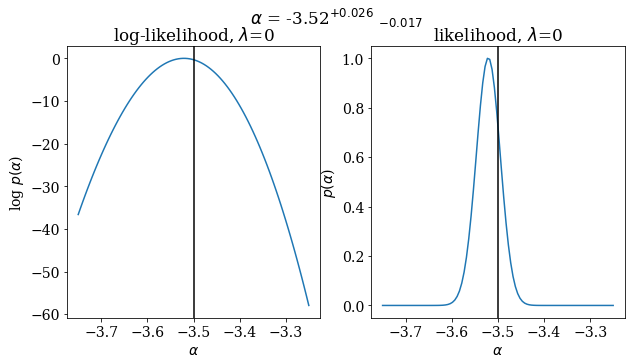

In [271]:
print("most likely alpha (IN SOURCE FRAME) =",mu_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_src, log_alpha_norm)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(alpha_range_src, np.exp(log_alpha_norm))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior.pdf')
plt.show()

### $\lambda$=1, alpha posterior

In [272]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True)

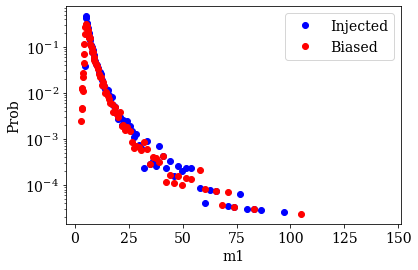

In [273]:
bins = np.geomspace(3, 150, 100)

m1_inj = df_mc["m1"] / (1+df_mc["z"])
y, X = np.histogram(m1_inj, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'bo', label='Injected')

y, X = np.histogram(m1_mu_sampled_biased, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'ro', label='Biased')

plt.xlabel("m1")
plt.ylabel("Prob")
plt.legend()

plt.semilogy()
plt.show()

From the Mathematica nb, a small increase in both Mc and eta results in lower m1, higher m2. The biased m1s are lower for high masses, which makes the power-law slope steeper.

In [275]:
log_p_alpha_lam_1_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha_min=alpha_inj-1.0, alpha_max=alpha_inj+0.5, n_alpha=100, \
    m1_min_int = 5., m1_max_int=200., n_m1_int=10000,\
    m1_min_pow = 5., m1_max_pow=100.,\
    Ns=len(m1_mu_sampled_biased), Nt=len(m1_mu_sampled_biased))
log_alpha_norm =log_p_alpha_lam_1_src - np.max(log_p_alpha_lam_1_src)

In [276]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_alpha_norm), alpha_range_src
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

mu_alpha = popt[0]
sig_alpha = popt[1]
print(popt)

bias_sigma = ((mu_alpha - alpha_inj)/sig_alpha)
print(rf"Injected alpha is {bias_sigma :.2f} sigma away")

[-3.88223697  0.02968648  0.07487304]
Injected alpha is -12.88 sigma away


In [315]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm, alpha_range_src)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.902455385448743, -3.882356550690459, -3.8516052224138875
Injected alpha is -12.434 sigma away


most likely alpha (IN SOURCE FRAME) = -3.8822369693676926


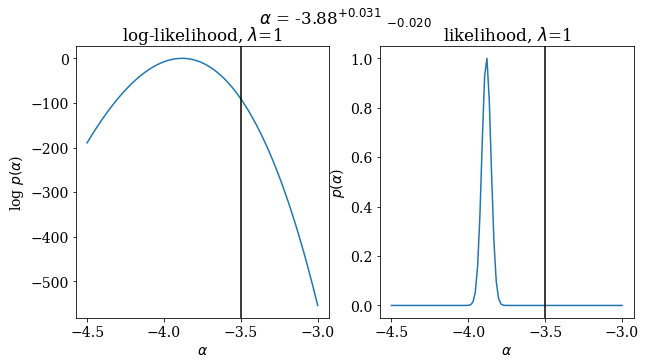

In [317]:
print("most likely alpha (IN SOURCE FRAME) =", mu_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_src, log_alpha_norm)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(alpha_range_src, np.exp(log_alpha_norm))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'alpha_{alpha_inj:.1f}_hyper_posterior_lam_1.pdf')
plt.show()

## m_min hyper-posterior

In [318]:
def log_likelihood_mmin(m1_mu_events, m1_sigma_events, \
    alpha=-3.5, \
    m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
    m1_max_int=200., n_m1_int=20000, \
    m1_max_pow=200., \
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros(n_m1_low)

    for m1_low_index in range(n_m1_low):
        m1_min_pow = m1_low_range[m1_low_index]
        m1_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

        total_int = 0

        for i in range(Nt):
            # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
            # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
            # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
            integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
            int_term = integrate.trapezoid(integrand, m1_int_range)
            if int_term==0:
                int_term=1

            total_int = total_int + np.log(Ns) + np.log(int_term)
            
        log_likelihoods[m1_low_index] = -Ns + total_int
        
    return log_likelihoods, m1_low_range


### $\lambda=0$, m_min posterior

In [319]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [320]:
log_p_mmin_lam_0, m1_low_range = log_likelihood_mmin(m1_mu_sampled, m1_sigma_events, \
    alpha=alpha_inj, \
    m1_low_min = 4.95, m1_low_max =5.05, n_m1_low=50,\
    m1_max_int=mmax_inj, n_m1_int=10000, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmin_norm =log_p_mmin_lam_0 - np.max(log_p_mmin_lam_0)

In [322]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmin_norm), m1_low_range
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[5.0, 0.6, 1.0])

mu_mmin = popt[0]
sig_mmin = popt[1]
print(popt)

bias_sigma = ((mu_mmin - mmin_inj)/sig_mmin)
print(rf"Injected m1_min is {bias_sigma :.2f} sigma away")

[ 4.99322054 -0.00662005 -0.01638439]
Injected m1_min is 1.02 sigma away


In [324]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm, m1_low_range)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 4.988978368939145, 4.993248753683228, 5.000152203958096
Injected mmin is -0.978 sigma away


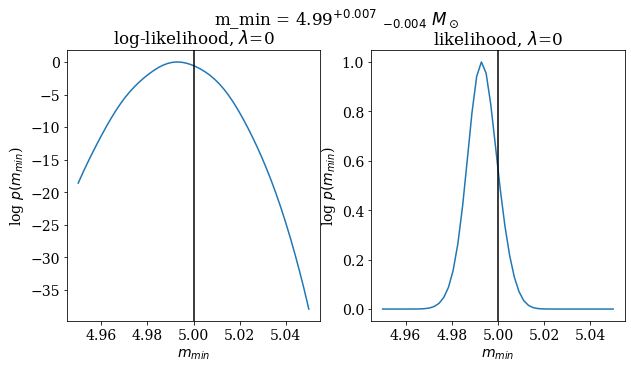

In [333]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range, log_mmin_norm)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_low_range, np.exp(log_mmin_norm))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("log $p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmin_hyper_posterior.pdf')
plt.show()

### $\lambda=1$, m_min posterior

In [334]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True)

In [336]:
log_p_mmin_lam_1, m1_low_range = log_likelihood_mmin(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha=alpha_inj, \
    m1_low_min = 4.45, m1_low_max = 4.85, n_m1_low=50,\
    m1_max_int=mmax_inj, n_m1_int=10000, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmin_norm =log_p_mmin_lam_1 - np.max(log_p_mmin_lam_1)

In [337]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmin_norm), m1_low_range
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[5.0, 0.6, 1.0])

mu_mmin = popt[0]
sig_mmin = popt[1]
print(popt)

bias_sigma = ((mu_mmin - mmin_inj)/sig_mmin)
print(rf"Injected m1_min is {bias_sigma :.2f} sigma away")

[ 4.62431621 -0.00526168 -0.01537594]
Injected m1_min is 71.40 sigma away


In [338]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm, m1_low_range)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 4.616502534570088, 4.623026573685256, 4.630323483607728
Injected mmin is -51.662 sigma away


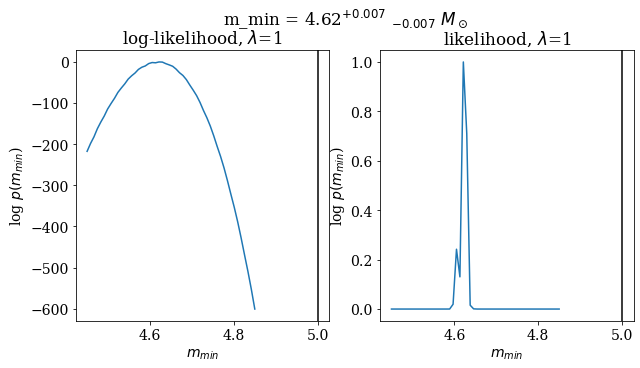

In [339]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range, log_mmin_norm)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_low_range, np.exp(log_mmin_norm))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("log $p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmin_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

## m_max hyper-posterior

In [138]:
def log_likelihood_mmax(m1_mu_events, m1_sigma_events, \
    alpha=alpha_inj, \
    m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
    m1_min_int=5., m1_max_int=100., n_m1_int=20000, \
    m1_min_pow=5., \
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    # m1_max_int=m1_high_max
    
    m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)
    log_likelihoods = np.zeros(n_m1_high)

    m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)

    for m1_high_index in range(n_m1_high):
        m1_max_pow = m1_high_range[m1_high_index]

        total_int = 0

        for i in range(Nt):
            # Need to set the integral to 1, s.t. log(1) = 0, if posterior is very far from the data and returns log(0) = -inf
            
            # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
            # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
            integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
            int_term = integrate.trapezoid(integrand, m1_int_range)
            if int_term==0:
                int_term=1
            
            total_int = total_int + np.log(Ns) + np.log(int_term)
            
        log_likelihoods[m1_high_index] = -Ns + total_int
        
    return log_likelihoods, m1_high_range

### $\lambda=0$, m_max posterior

In [365]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [366]:
log_p_mmax_lam_0, m1_high_range = log_likelihood_mmax(m1_mu_sampled, m1_sigma_events, \
    alpha=alpha_inj,
    m1_high_min = 80.0, m1_high_max = 180., n_m1_high=100,\
    m1_min_int=mmin_inj, n_m1_int=10000, \
    m1_min_pow=mmin_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmax_norm =log_p_mmax_lam_0 - np.max(log_p_mmax_lam_0)

In [369]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmax_norm), m1_high_range
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[100., 0.6, 1.0])

mu_mmax = popt[0]
sig_mmax = popt[1]
print(popt)

bias_sigma = ((mu_mmax - mmax_inj)/sig_mmax)
print(rf"Injected m1_max is {bias_sigma :.2f} sigma away")

[101.65537489   5.22024587  10.80230474]
Injected m1_max is 0.32 sigma away


In [370]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm, m1_high_range)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 99.86997121660475, 104.11031407696112, 121.26333753702261
Injected mmin is 0.240 sigma away


most likely m1_max (IN SOURCE FRAME) = 101.65537488803335


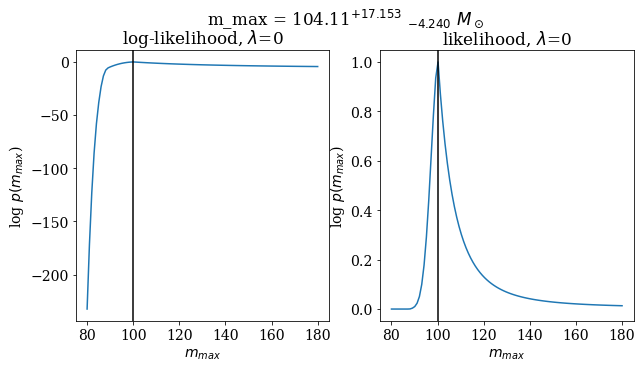

In [371]:
print("most likely m1_max (IN SOURCE FRAME) =",mu_mmax)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range, log_mmax_norm)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_high_range, np.exp(log_mmax_norm))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior.pdf')
plt.show()

### $\lambda=1$, m_max posterior

In [373]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True)

In [374]:
log_p_mmax_lam_1, m1_high_range = log_likelihood_mmax(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha=alpha_inj,
    m1_high_min = 80.0, m1_high_max = 300., n_m1_high=100,\
    m1_min_int=mmin_inj, m1_max_int=300., n_m1_int=10000, \
    m1_min_pow=mmin_inj, \
    Ns=len(m1_mu_sampled_biased), Nt=len(m1_mu_sampled_biased))
    
    
log_mmax_norm =log_p_mmax_lam_1 - np.max(log_p_mmax_lam_1)

In [378]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmax_norm), m1_high_range
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[100., 0.6, 1.0])

mu_mmax = popt[0]
sig_mmax = popt[1]
print(popt)

bias_sigma = ((mu_mmax - mmax_inj)/sig_mmax)
print(rf"Injected m1_max is {bias_sigma :.2f} sigma away")

[142.05431304  87.24862703 181.90492579]
Injected m1_max is 0.48 sigma away


In [379]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm, m1_high_range)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 128.31388193145008, 161.74571609139488, 239.4914911322564
Injected mmin is 0.794 sigma away


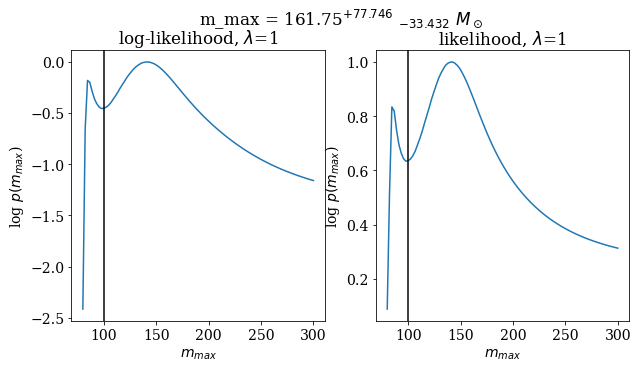

In [380]:
# print(f"most likely m1_max (IN SOURCE FRAME) = {m1_high_range[np.argmax(log_mmax_norm)]:.3f}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range, log_mmax_norm)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_high_range, np.exp(log_mmax_norm))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

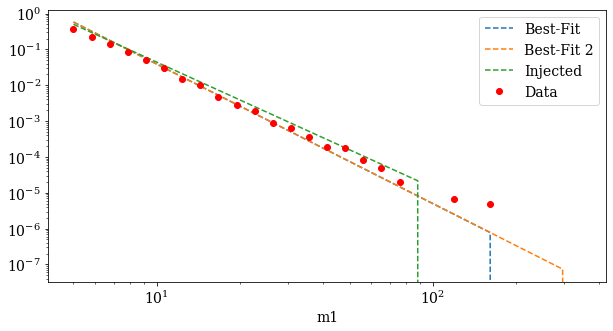

In [161]:

bins = np.geomspace(5, 400, 30)

y, X = np.histogram(m1_mu_sampled_biased, bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()



plt.figure(figsize=(10, 5))
plt.plot(X, p_m1(X,  -3.89, 5, 171), '--', label='Best-Fit')
plt.plot(X, p_m1(X,  -3.89, 5, 300), '--', label='Best-Fit 2')

plt.plot(X, p_m1(X,  alpha_inj, 5, mmax_inj), '--', label='Injected')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(30, 70)

plt.show()

# 2D inference (Manual)

## alpha, m1_max

In [381]:
def log_likelihood_alpha_m1max(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=10, \
        m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
        m1_min_int=5., n_m1_int=20000, \
        m1_min_pow=5., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    m1_max_int=m1_high_max

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)

    log_likelihoods = np.zeros((n_m1_high, n_alpha))

    for m1_high_index in range(n_m1_high):
        m1_max_pow = m1_high_range[m1_high_index]

        m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)
        
        for a in range(n_alpha):
            
            alpha = alpha_range[a]
            total_int = 0

            for i in range(Nt):
                # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
                # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
                # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
                integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
                int_term = integrate.trapezoid(integrand, m1_int_range)
                if int_term==0:
                    int_term=1
                    
                total_int = total_int + np.log(Ns) + np.log(int_term)
                
            log_likelihoods[m1_high_index, a] = -Ns + total_int
        
        
           
    return log_likelihoods, alpha_range, m1_high_range

### $\lambda=0$

In [38]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [382]:
alpha_min = alpha_inj-0.25
alpha_max=alpha_inj+0.25
n_alpha=50
m1_high_min = 80.0
m1_high_max = 180.0
n_m1_high=50

alpha_range_a_mmax = np.linspace(alpha_min, alpha_max, n_alpha)
m1_high_range_a_mmax = np.linspace(m1_high_min, m1_high_max, n_m1_high)

fname_alpha_mmax = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_log_likelihoods"    


In [40]:
log_likelihoods_a_mmax, alpha_range_a_mmax, m1_high_range_a_mmax = log_likelihood_alpha_m1max(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_high_min = m1_high_min, m1_high_max = m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=5., n_m1_int=10000, \
    m1_min_pow=5.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))

log_likelihoods_norm_a_mmax = log_likelihoods_a_mmax - np.max(log_likelihoods_a_mmax)
    

In [42]:
# # Save likelihoods to file
# np.savetxt(fname_alpha_mmax, log_likelihoods_norm_a_mmax)

In [383]:
# Load likelihoods from file
log_likelihoods_norm_a_mmax = np.loadtxt(fname_alpha_mmax)

In [384]:
index_max = np.argmax(log_likelihoods_norm_a_mmax)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmax.shape)

print(index_max)
m_max_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmax[alpha_index_2d])
print("m1_max:", m1_high_range_a_mmax[m_max_index_2d])

(8, 24)
alpha: -3.5051020408163267
m1_max: 96.3265306122449


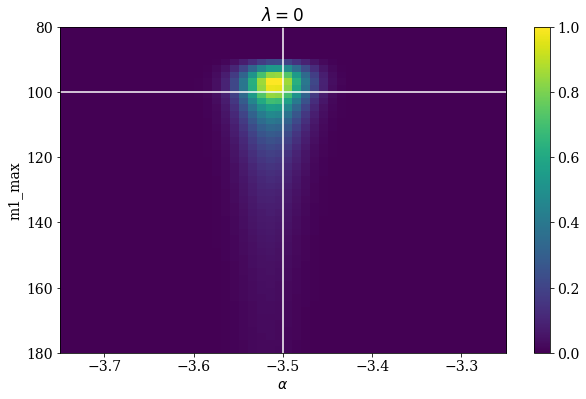

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.imshow((log_likelihoods_norm_a_mmax), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmax), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])

plt.colorbar()

plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmax_inj, color='w')

plt.xlabel("$\\alpha$")
plt.ylabel("m1_max")
plt.title("$\lambda=0$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_LOG.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_EXP.pdf")
plt.show()
    


most likely m_max (IN SOURCE FRAME) = 96.3265306122449


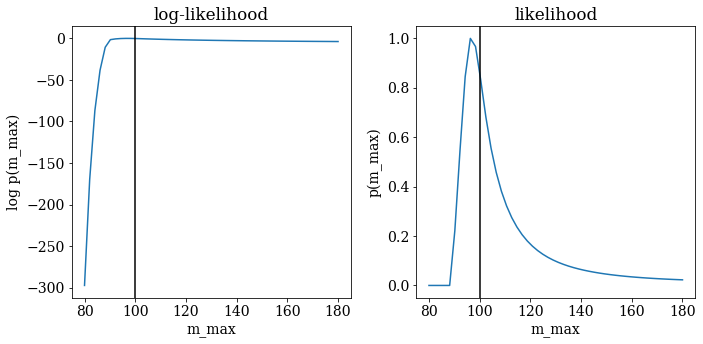

In [45]:
print("most likely m_max (IN SOURCE FRAME) =",m1_high_range_a_mmax[np.argmax(log_likelihoods_norm_a_mmax[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_a_mmax, log_likelihoods_norm_a_mmax[:,alpha_index_2d])
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log p(m_max)")
axes[0].set_xlabel("m_max")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax[:,alpha_index_2d]))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("p(m_max)")
axes[1].set_xlabel("m_max")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

### $\lambda=1$

In [20]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True)

In [30]:
alpha_min = alpha_inj-0.65
alpha_max=alpha_inj+0.05
n_alpha=50
m1_high_min = 70.0
m1_high_max = 500.0
n_m1_high=50

alpha_range_a_mmax = np.linspace(alpha_min, alpha_max, n_alpha)
m1_high_range_a_mmax = np.linspace(m1_high_min, m1_high_max, n_m1_high)

fname_alpha_mmax_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lambda_1_log_likelihoods"    


In [31]:
log_likelihoods_a_mmax_lam_1, alpha_range_a_mmax, m1_high_range_a_mmax = log_likelihood_alpha_m1max(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_high_min = m1_high_min, m1_high_max = m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=5., n_m1_int=10000, \
    m1_min_pow=5.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))

log_likelihoods_norm_a_mmax_lam_1 = log_likelihoods_a_mmax_lam_1 - np.max(log_likelihoods_a_mmax_lam_1)
    

In [32]:
np.savetxt(fname_alpha_mmax_lam_1, log_likelihoods_norm_a_mmax_lam_1)

In [33]:
log_likelihoods_norm_a_mmax_lam_1 = np.loadtxt(fname_alpha_mmax_lam_1)

In [36]:
index_max = np.argmax(log_likelihoods_norm_a_mmax_lam_1)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmax_lam_1.shape)

print(index_max)
m_max_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmax[alpha_index_2d])
print("m1_max:", m1_high_range_a_mmax[m_max_index_2d])

(7, 18)
alpha: -3.8928571428571432
m1_max: 131.42857142857142


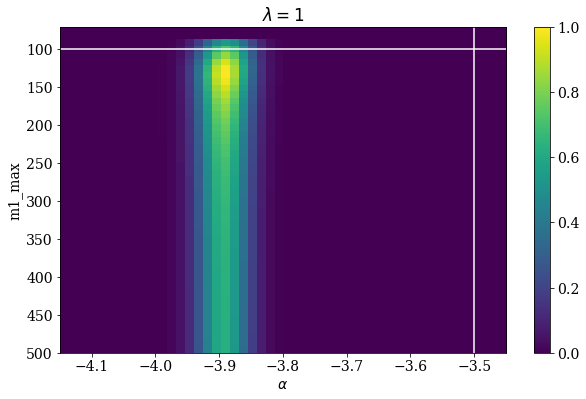

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.imshow((log_likelihoods_norm_a_mmax_lam_1), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmax_lam_1), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])

plt.colorbar()

plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmax_inj, color='w')

plt.xlabel("$\\alpha$")
plt.ylabel("m1_max")
plt.title("$\lambda=1$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lam_1_LOG.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lam_1_EXP.pdf")
plt.show()
    


most likely m_max (IN SOURCE FRAME) = 131.42857142857142


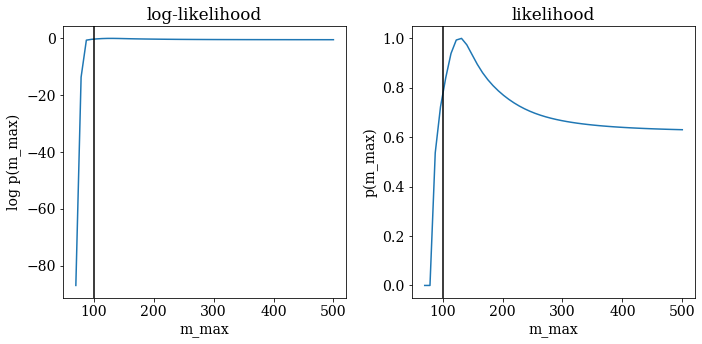

In [39]:
print("most likely m_max (IN SOURCE FRAME) =",m1_high_range_a_mmax[np.argmax(log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_a_mmax, log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d])
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log p(m_max)")
axes[0].set_xlabel("m_max")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d]))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("p(m_max)")
axes[1].set_xlabel("m_max")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

# alpha, m1_min

In [49]:
def log_likelihood_alpha_m1min(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=50, \
        m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
        m1_max_int=200., n_m1_int=20000, \
        m1_max_pow=200., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros((n_m1_low, n_alpha))

    for m1_low_index in range(n_m1_low):
        m1_min_pow = m1_low_range[m1_low_index]
        m1_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

        for a in range(n_alpha):
            
            alpha = alpha_range[a]
            total_int = 0

            for i in range(Nt):
                # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
                # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
                # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
                integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
                int_term = integrate.trapezoid(integrand, m1_int_range)

                if int_term==0:
                    int_term=1
                    
                total_int = total_int + np.log(Ns) + np.log(int_term)
                
            log_likelihoods[m1_low_index, a] = -Ns + total_int
        
        
           
    return log_likelihoods, alpha_range, m1_low_range

### $\lambda=0$

In [14]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [110]:
alpha_min = alpha_inj-0.25
alpha_max = alpha_inj+0.25
n_alpha = 50
m1_low_min = mmin_inj-0.05
m1_low_max = mmin_inj+0.05
n_m1_low= 50

alpha_range_a_mmin = np.linspace(alpha_min, alpha_max, n_alpha)
m1_low_range_a_mmin = np.linspace(m1_low_min, m1_low_max, n_m1_low)

fname_alpha_mmin = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_log_likelihoods" 


In [16]:
log_likelihoods_norm_a_mmin, alpha_range_a_mmin, m1_low_range_a_mmin = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=100., n_m1_int=10000, \
    m1_max_pow=100.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_likelihoods_norm_a_mmin = log_likelihoods_norm_a_mmin - np.max(log_likelihoods_norm_a_mmin)

In [22]:
# np.savetxt(fname_alpha_mmin, log_likelihoods_norm_a_mmin)

In [111]:
log_likelihoods_norm_a_mmin = np.loadtxt(fname_alpha_mmin)

In [112]:
index_max = np.argmax(log_likelihoods_norm_a_mmin)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmin.shape)

m_min_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmin[alpha_index_2d])
print("m1_min:", m1_low_range_a_mmin[m_min_index_2d])

index_max

alpha: -3.5051020408163267
m1_min: 4.996938775510204


(23, 24)

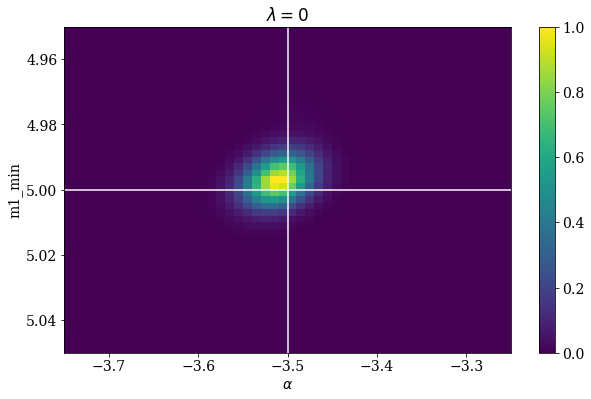

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.imshow((log_likelihoods_norm_a_mmin), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmin), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])


plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmin_inj, color='w')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")
plt.title("$\lambda=0$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_LOG.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_EXP.pdf")
plt.show()
    
# 

most likely m_min (IN SOURCE FRAME) = 4.996938775510204


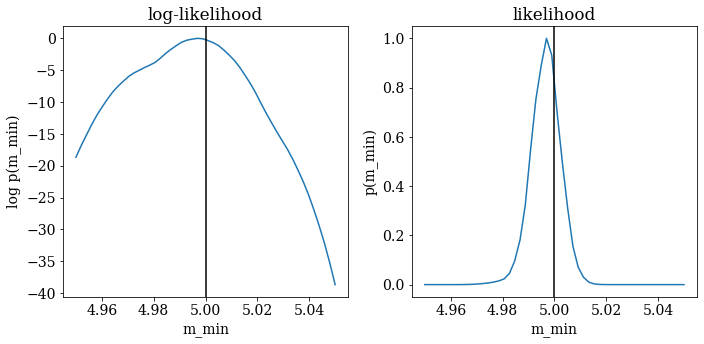

In [26]:
print("most likely m_min (IN SOURCE FRAME) =",m1_low_range_a_mmin[np.argmax(log_likelihoods_norm_a_mmin[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_a_mmin, log_likelihoods_norm_a_mmin[:,alpha_index_2d])
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log p(m_min)")
axes[0].set_xlabel("m_min")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin[:,alpha_index_2d]))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("p(m_min)")
axes[1].set_xlabel("m_min")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

### $\lambda=1$

In [51]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True)

In [114]:
alpha_min = alpha_inj-0.25
alpha_max = alpha_inj+0.25
n_alpha = 50
m1_low_min = mmin_inj-0.50
m1_low_max = mmin_inj+0.05
n_m1_low= 50

alpha_range_a_mmin = np.linspace(alpha_min, alpha_max, n_alpha)
m1_low_range_a_mmin = np.linspace(m1_low_min, m1_low_max, n_m1_low)

fname_alpha_mmin_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_lambda_1_log_likelihoods" 


In [53]:
log_likelihoods_norm_a_mmin_lam_1, alpha_range_a_mmin, m1_low_range_a_mmin = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=100., n_m1_int=10000, \
    m1_max_pow=100.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_likelihoods_norm_a_mmin_lam_1 = log_likelihoods_norm_a_mmin_lam_1 - np.max(log_likelihoods_norm_a_mmin_lam_1)

In [64]:
# np.savetxt(fname_alpha_mmin_lam_1, log_likelihoods_norm_a_mmin_lam_1)

In [115]:
log_likelihoods_norm_a_mmin_lam_1 = np.loadtxt(fname_alpha_mmin_lam_1)

In [116]:
index_max = np.argmax(log_likelihoods_norm_a_mmin_lam_1)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmin_lam_1.shape)

m_min_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmin[alpha_index_2d])
print("m1_min:", m1_low_range_a_mmin[m_min_index_2d])

index_max

alpha: -3.4030612244897958
m1_min: 4.612244897959184


(10, 34)

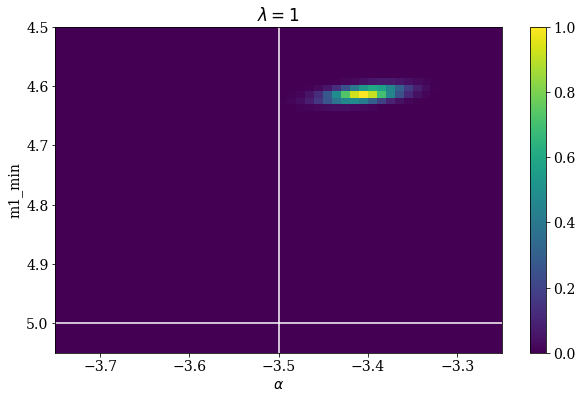

In [117]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.imshow((log_likelihoods_norm_a_mmin_lam_1), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmin_lam_1), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])


plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmin_inj, color='w')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")
plt.title("$\lambda=1$")


# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_LOG_lam_1.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_EXP_lam_1.pdf")
plt.show()
    
# 

# Alpha Bias vs N_det

In [ ]:
def get_avg_sigma_boot(n_samples, n_bootstrap):

    n_samples = int(n_samples)

    sigma_devs_boot = np.zeros(n_bootstrap)

    for n in range(n_bootstrap):
        
        sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
        df_mc = df_mc_raw.iloc[sample_indices]
        df_eta = df_eta_raw.iloc[sample_indices]

        # Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
        z = df_mc["z"]
        mchirp = (df_mc["Mc"])/ (1+z)
        eta = df_mc["eta"]

        sigMc_raw = df_mc["Mc_stat_err"]
        sigEta = df_eta["eta_stat_err"]
        sigZ = df_mc["z_stat_err"]

        sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


        aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
        aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
        aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
        aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
        m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
        m1_sigma_events = m1_sigma_events.values


        # Use biased mc, eta for the m1_mu list only
        bias_eta = df_eta["bias_19"]
        bias_mc = df_mc["bias_19"]

        mchirp = (df_mc["Mc"] + bias_mc)
        eta = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m1_biased = conv.mass1_from_mchirp_eta(mchirp, eta)
        m1_mu_detections = m1_biased / (1+z)
        # sample mu from the detection gaussians to avoid Biases
        m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

        log_p_alpha_lam_0_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
        alpha_min=alpha_inj-1.0, alpha_max=alpha_inj+0.5, n_alpha=30, \
        m1_min_int = 5., m1_max_int=200., n_m1_int=20000,\
        m1_min_pow = 5., m1_max_pow=100.,\
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"]))
        log_alpha_norm =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)   


        target_func = normal_dist
        y, X = np.exp(log_alpha_norm), alpha_range_src
        popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

        mu_alpha = popt[0]
        sig_alpha = popt[1]
        sigma_devs_boot[n] = np.abs(alpha_inj - mu_alpha)/sig_alpha
        # print(rf"Injected alpha is {sigma_devs_boot[n] :.2f} sigma away")

    print(rf"For N = {n_samples} detections, injected alpha is {np.average(sigma_devs_boot) :.2f} sigma away on avg.")
    return np.median(sigma_devs_boot), np.std(sigma_devs_boot)

In [ ]:
N_samples_range = [10., 25., 50., 100., 150.]
med_sigma_boot_range = np.zeros(len(N_samples_range))
std_sigma_boot_range = np.zeros(len(N_samples_range))

In [ ]:
med_sigma_boot_range[0], std_sigma_boot_range[0] = get_avg_sigma_boot(n_samples=N_samples_range[0], n_bootstrap=100)

For N = 10 detections, injected alpha is 0.82 sigma away on avg.


In [ ]:
med_sigma_boot_range[1], std_sigma_boot_range[1] = get_avg_sigma_boot(n_samples=N_samples_range[1], n_bootstrap=100)

For N = 25 detections, injected alpha is 0.99 sigma away on avg.


In [ ]:
med_sigma_boot_range[2], std_sigma_boot_range[2] = get_avg_sigma_boot(n_samples=N_samples_range[2], n_bootstrap=100)

For N = 50 detections, injected alpha is 1.18 sigma away on avg.


In [ ]:
med_sigma_boot_range[3], std_sigma_boot_range[3] = get_avg_sigma_boot(n_samples=N_samples_range[3], n_bootstrap=100)

For N = 100 detections, injected alpha is 1.36 sigma away on avg.


In [ ]:
med_sigma_boot_range[4], std_sigma_boot_range[4] = get_avg_sigma_boot(n_samples=N_samples_range[4], n_bootstrap=100)

For N = 150 detections, injected alpha is 1.69 sigma away on avg.


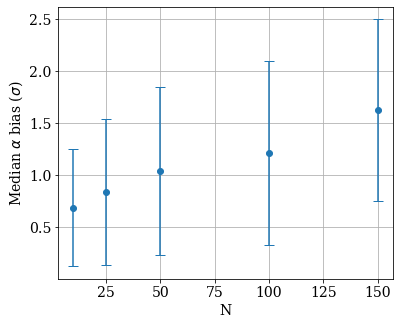

In [ ]:
fig, axes = plt.subplots(figsize=(6, 5))
plt.errorbar(N_samples_range, med_sigma_boot_range, yerr=std_sigma_boot_range, fmt='o', capsize=5.0)
plt.xlabel("N")
plt.ylabel("Median $\\alpha$ bias ($\sigma$)")
plt.grid()
# plt.semilogy()
# plt.savefig(plotdir+'alpha_3.5_lam_1_n_vs_bias.pdf')
plt.show()

# 3D Inference, MCMC test

https://github.com/kazewong/TutorialsAndExplains/blob/main/HBA_explain/Session_version.ipynb

In [ ]:
import emcee
import corner

In [ ]:
Ns = len(df_mc)
Nt = Ns

def lnprob(m1_mu, m1_sigma, m1_min_pow, m1_max_pow, alpha):

    m1_int_range = np.geomspace(0, 200, 5000)

    total_int = 0

    for i in range(len(m1_mu)):
        integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * trunc_normal_dist(m1_int_range, m1_mu[i], m1_sigma[i])
        int_term = integrate.trapezoid(integrand, m1_int_range)

        total_int = total_int + np.log(int_term)

    return total_int

In [ ]:
mmin_low, mmin_hi = [3,7]
mmax_low, mmax_hi = [90,110]
alpha_low, alpha_hi = [-4.5,-2.5]



def population_posterior(params, m1_mu, m1_sigma):
    mmin = params[0]
    mmax = params[1]
    alpha = params[2]
    if (mmin>mmin_hi) or (mmin<mmin_low):
        return -np.inf
    if (mmax>mmax_hi) or (mmax<mmax_low):
        return -np.inf
    if (alpha>alpha_hi) or (alpha<alpha_low):
        return -np.inf

    else:
        return lnprob(m1_mu, m1_sigma, mmin, mmax, alpha)

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
z = df_mc["z"]
mchirp = df_mc["Mc"]/ (1+z)
eta = df_mc["eta"]

sigMc_raw = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]
sigZ = df_mc["z_stat_err"]

sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


m1_mu_detections = df_mc["m1"] / (1+z)

aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
m1_sigma_events = m1_sigma_events.values

# sample mu from the detection gaussians to avoid Biases
m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

In [ ]:
ndim, nwalkers = 3, 50
ivar = 1. / np.random.rand(ndim)
p0 = np.random.uniform([mmin_low,mmax_low,alpha_low], [mmin_hi,mmax_hi,alpha_hi], size=(nwalkers,ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, args=[m1_mu_sampled, m1_sigma_events])
sampler.run_mcmc(p0, 100)



/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


State([[  5.00036152 111.38111065  -3.74701892]
 [  4.99705193 102.62634966  -3.68501524]
 [  4.99837552  93.1685037   -3.59876167]
 [  4.95979029  87.53823879  -3.52590523]
 [  4.99768617  94.59484943  -3.58750938]
 [  7.41035347 106.707456    -2.90439416]
 [  7.86298835  94.75132685  -5.82173443]
 [  5.00051396 114.70480723  -3.65999393]
 [  5.00049184  99.95374916  -3.55041319]
 [  8.35063755  90.94081938  -3.04264088]
 [  9.57837543  80.22492161  -2.01579858]
 [  8.03926945 109.8147907   -2.94253024]
 [  4.96099206 100.41621693  -3.57846999]
 [  4.91962228 102.07538855  -3.59988518]
 [  4.99925128  94.99120767  -3.58466651]
 [  6.4677974   86.26533921  -5.97580223]
 [  8.43734108 108.22733709  -5.57255021]
 [  8.83225324 104.53703559  -4.713414  ]
 [  9.54033653 106.32787387  -4.62531024]
 [  4.96035824 105.11256442  -3.53836553]
 [  5.03545087  99.49582192  -3.41165951]
 [  8.30821597  95.85350222  -3.82481375]
 [  4.96070987 100.25098953  -3.66749433]
 [  4.96006356 100.46771536 

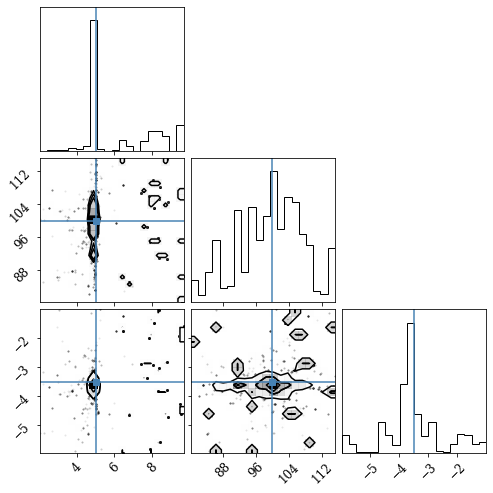

In [ ]:
samples = sampler.flatchain

# samples
fig = corner.corner(samples, truths=[mmin_inj, mmax_inj, alpha_inj])

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

samples[:, 2] = np.exp(samples[:, 2])
mmin_mcmc, mmax_mcmc, alpha_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))


In [ ]:
print(mmin_mcmc)
print(mmax_mcmc)
print(alpha_mcmc)

(5.000315633291784, 3.494456366976973, 0.04138945577934727)
(99.82221852932142, 6.566388479752234, 9.040839065277765)
(0.026454812484407307, 0.029185976903127388, 0.005326317536527618)


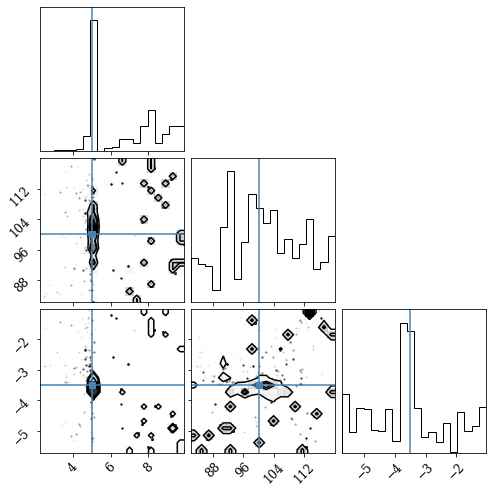

In [ ]:
# samples = sampler.flatchain

# # samples
# fig = corner.corner(samples, truths=[mmin_inj, mmax_inj, alpha_inj])

In [ ]:


import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.ndimage import gaussian_filter
params = {'axes.labelsize': 32,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 32,
          'axes.linewidth': 2,
          'legend.fontsize': 28,
          'xtick.labelsize': 28,
          'xtick.top': True,
          'ytick.labelsize': 20,
          'ytick.right': True,
          'axes.grid' : False,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
#          'axes.formatter.useoffset': False,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rcParams.update(params)


def fill_corner(fig,data,ndim,axis,color='C0',true_val=None,zorder=1,lw=3,style='-',smooth1d = 0.01,no_fill_contours=False,fill_contours=True,alpha=1,levels=[0.68,0.95]):
    for i in range(ndim):
        for j in range(i+1):
            ax = fig.axes[np.sum(np.arange(i+1))+j]
            if i==j:
                ax.hist(data[i],bins=axis[i],histtype='step',lw=lw,color=color,density=True,zorder=zorder)
                ylim = ax.get_ylim()
                ax.set_xlim(axis[i][0],axis[i][-1])
                ax.set_ylim(ylim[0],ylim[1])
                if true_val is not None:
                    ax.vlines(true_val[i],ylim[0],ylim[1],color=color,lw=lw,zorder=zorder)

            elif j<i:
                corner.hist2d(data[j],data[i],bins=[axis[j],axis[i]],plot_datapoints=False,plot_density=False,ax=ax,levels=levels,fill_contours=fill_contours,smooth1d = smooth1d,color=color,no_fill_contours=True,contour_kwargs={'linewidths':lw,'zorder':zorder,'linestyles':style,'colors':color})
                ax.set_ylim(axis[i][0],axis[i][-1])
                ax.set_xlim(axis[j][0],axis[j][-1])
                if true_val is not None:
                    ax.scatter(true_val[j],true_val[i],color=color,marker='*',s=100,zorder=20)
                    ax.vlines(true_val[j],ax.get_ylim()[0],ax.get_ylim()[1],color=color,lw=3)
                    ax.hlines(true_val[i],ax.get_xlim()[0],ax.get_xlim()[1],color=color,lw=3)


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


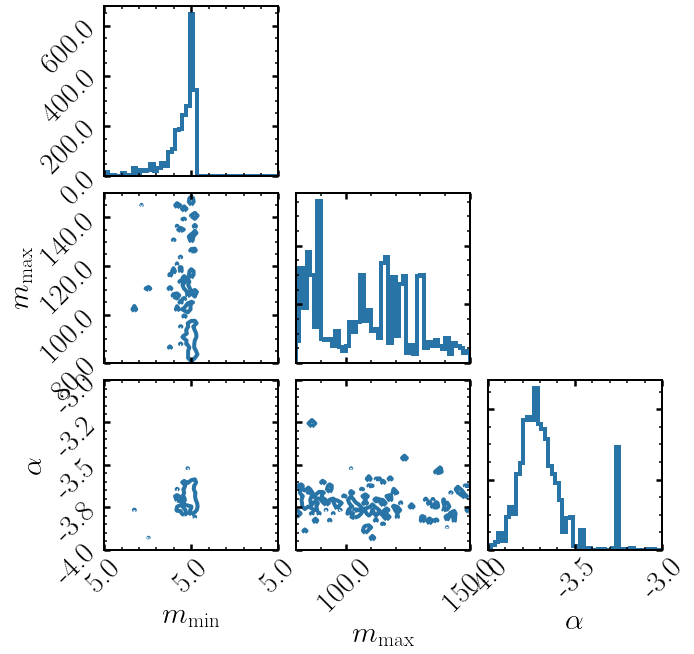

In [ ]:
Ndim = 3
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(4.99,5.01,Nbins),np.linspace(mmax_low,mmax_hi,Nbins),np.linspace(-4.0, -3.0, Nbins)])
xlabel = [r'$m_{\rm min}$',r'$m_{\rm max}$',r'$\alpha$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,levels=[0.6])
counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')
plt.tight_layout()


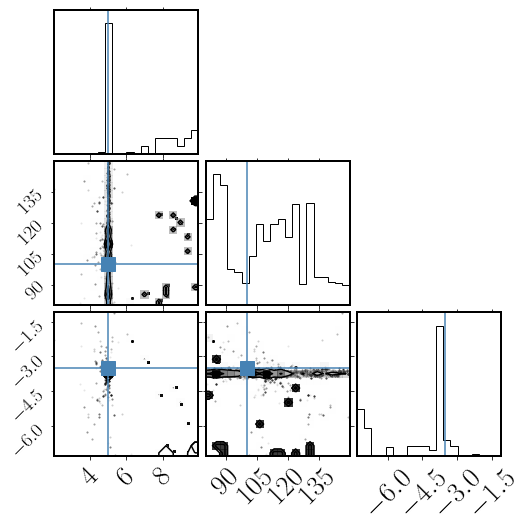

In [ ]:
samples = sampler.flatchain

# samples
fig = corner.corner(samples, truths=[mmin_inj, mmax_inj, alpha_inj])


In [ ]:
reader = emcee.backends.HDFBackend("ndim_3_nwalkers_30_nsteps_500.h5")
flatchain = reader.get_chain()

AttributeError: You must run the sampler with 'store == True' before accessing the results

# Scipy curve_fit test

In [38]:
mask = (m1_mu_detections<2000)

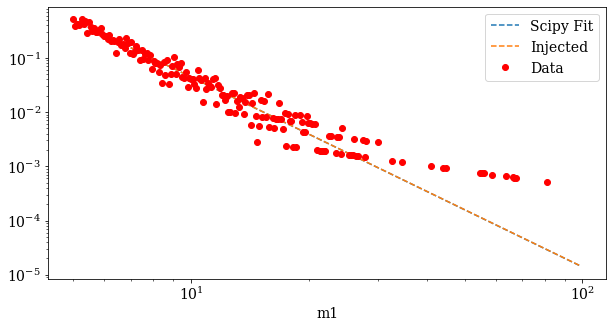

[-3.50176719e+00  4.99999999e+00  2.64760687e+04]


In [41]:
target_func = p_m1
bins = np.geomspace(5, 100, 300)

y, X = np.histogram(m1_mu_detections[mask], bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()


popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 5, 100])

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label='Scipy Fit')
# plt.plot(X, p_m1(X,  mu_alpha, 5, 100), '--', label='Best-Fit')
plt.plot(X, p_m1(X,  alpha_inj, 5, 100), '--', label='Injected')

# plt.plot(X, len(df_mc)*pareto.pdf(X, b)/70.0, label='pareto')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(30, 70)

plt.show()


print(popt)